In [31]:
# This script:
# 1) generates png files that can be assembled into a video using ffmpeg in linux
# 2) generates a kml file that can be loaded into Google Earth Pro for interactive
#    3d plotting
# 3) allows playing around with python code for loading and drawing geographically
#    related data
#
# CAVEATS:
# 1) Jupyter notebooks do not seem to support playing a succession of images to
#    effectively display a video, so this script does not show moving graphics while
#    it executes. The SharkPathGallher.py script can be used to get the same outputs
#    along with video 

In [32]:
# pip install basemap
# pip install matplotlib
# pip install numpy
# pip install pandas
# pip install scipy


In [33]:
import csv
import datetime
from mpl_toolkits.basemap import Basemap, cm
import math
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
from scipy.interpolate import griddata
from scipy.io import netcdf
from time import sleep


In [34]:
# Constant values that should not be changed
COL_ID = 0
COL_DATE = 1
COL_LON = 2
COL_LAT = 3

In [35]:
# Low level functions are defined here, but not executed until later
def drawBathysphere (map, elecdf, loncdf, latcdf, contours):
    print ("drawBathysphere")    
    # Convert netcdf arrays to regular array, with components transposed
    ele = np.zeros ((elecdf.shape[1], elecdf.shape[0]))
    lon = np.zeros ((elecdf.shape[1], elecdf.shape[0]))
    lat = np.zeros ((elecdf.shape[1], elecdf.shape[0]))
    for i in range (elecdf.shape[1]):
        for j in range (elecdf.shape[0]):
            ele [i] [j] = elecdf [j] [i]
            lon [i] [j] = loncdf [i]
            lat [i] [j] = latcdf [j]
    x, y = map (lon, lat)
    # cmap = cm.s3pcpn = blue, black, white brown
    # cmap = cm.Blues_r
    # cmap = plt.cm.get_cmap('Blues'))
    # cmap = plt.cm.get_cmap('RdBu'))
    # cmap = plt.cm.get_cmap('Dark2'))        
    cs = map.contourf (x, y, ele, contours, cmap = plt.cm.get_cmap('Blues'))

    # Color scale
    cbar = map.colorbar (cs, location = 'right', pad = '5%')
    cbar.set_label ('Elevation (meters)')

def drawCircle(map):
    # This requires
    #   from matplotlib.patches import Circle, Rectangle
    # Show circle at northernmost point in nova scotia which is northwest of Meat Point, according
    # to https://stackoverflow.com/questions/49134634/how-to-draw-circle-in-basemap-or-add-artiste
    circle = Circle (xy = map (-60.593352, 47.041354), radius = (map.ymax - map.ymin) / 60, fill = False)
    plt.gca().add_patch (circle)

def drawContinents(map):
    print ("drawContinents")    
    map.drawcoastlines (linewidth = 0.25)
    map.drawcountries (linewidth = 0.25)
    #map.fillcontinents (color = 'coral', lake_color = 'aqua') # Overwrites land portions of quivers drawn later
    map.drawmapboundary (fill_color = 'aqua')
    map.drawmeridians (np.arange (0, 360, 10))
    map.drawparallels (np.arange (-90, 90, 10))
    
def drawCurrent (map, lon, lat, u, v):
    print ("drawCurrent")    
    map.quiver (lon, lat, u, v)

def drawDeclinationContours (map, lon, lat, dec):
    print ("drawDeclinationContours")    
    map.contour (lon, lat, dec)
    
def drawDeclinationVectors (map, lon, lat, udec, vdec):
    print ("drawCurrent")    
    # Increase scale for smaller vectors
    map.quiver (lon, lat, udec, vdec, scale = 12, color = 'r') 

def drawLine (map, LINECOLOR, id, lonLast, latLast, lon, lat, moves, miles):  
    if id in lonLast:
        # Draw a line
        lons = [lonLast [id], lon]
        lats = [latLast [id], lat]
        map.plot (lons, lats, linewidth = 1.2, color = LINECOLOR, latlon = True)
        moves += 1
        miles += milesMoved (lonLast [id], latLast [id], lon, lat)
    return moves, miles

def drawSharkPath (map, useBetterMap, LINECOLOR, FILESHARK, IMGEXTENSION, \
                   fKml, waypoints, \
                   lonmin, lonmax, latmin, latmax):    
    # Shark waypoints. There can be multiple ids so lonLast and latLast are vectors indexed by id
    lonLast = {}
    latLast = {}
    datLast = waypoints [0][COL_DATE]
    imgLast = 0
    moves = 0
    miles = 0
    kmlPoints = {} # First index is id, second index is date, value is '<lon>,<lat>' string
    for row in waypoints:
        id  = row [COL_ID]
        dat = row [COL_DATE]
        # For debugging
        #if dat > pd.to_datetime ('10/21/2015', format='%m/%d/%Y'):
        #    break;
        lon = row [COL_LON]
        lat = row [COL_LAT]
        moves, miles = drawLine (map, LINECOLOR, id, lonLast, latLast, lon, lat, moves, miles)
        imgLast, moves, miles = moveDaysForward (useBetterMap, FILESHARK, IMGEXTENSION, \
                                                 datLast, dat, \
                                                 lonmin, lonmax, latmin, latmax, \
                                                 imgLast, moves, miles)
        kmlFileWrite (fKml, kmlPoints, id, dat, lon, lat)
        
        lonLast [id] = lon
        latLast [id] = lat
        datLast = dat
    kmlFileWriteAll (fKml, kmlPoints)
    kmlFileClose (fKml)
    
def kmlFileClose (fKml):
    fKml.write ('</Document>\n')
    fKml.write ('</kml>\n')

def kmlFileOpen (idsForKml):    
    FILEKML = 'outputs/gallagher.kml'
    fKml = open (FILEKML, 'w')
    fKml.write ('<?xml version="1.0" encoding="UTF-8"?>\n')
    fKml.write ('<kml xmlns="http://www.opengis.net/kml/2.2">\n')
    fKml.write ('<Document>\n')
    fKml.write ('  <LookAt>\n')
    fKml.write ('    <longitude>-68.38</longitude>\n')
    fKml.write ('    <latitude>41.27</latitude>\n')
    fKml.write ('    <altitude>0</altitude>\n')
    fKml.write ('    <range>687414</range>\n')
    fKml.write ('    <tilt>0.0303</tilt>\n')
    fKml.write ('    <heading>0</heading>\n')                
    fKml.write ('  </LookAt>\n')
    return fKml

def kmlFileWrite (fKml, kmlPoints, id, dat, lon, lat):
    LIFETIME = datetime.timedelta(hours=4)
    if not id in kmlPoints:
        kmlPoints [id] = {}
    kmlPoints [id] [dat] = '{},{}' . format (lon, lat)
    
def kmlFileWriteAll (fKml, kmlPoints):
    # Colors to disinguish sharks and also match points with paths
    colors = ['ffff0000', \
              'ff00ff00', \
              'ff0000ff', \
              'ffff00ff', \
              'ff00ffff', \
              'ffffff00', \
              'ffffffff']
    for indexColor in range (len (colors)):
        color = colors [indexColor]
        fKml.write ('  <StyleMap id="mapcolor{}">\n' . format (indexColor))
        fKml.write ('    <Pair>\n')
        fKml.write ('      <key>normal</key>\n')
        fKml.write ('      <styleUrl>#color{}</styleUrl>\n' . format (indexColor))
        fKml.write ('    </Pair>\n')
        fKml.write ('    <Pair>\n')
        fKml.write ('      <key>highlight</key>\n')
        fKml.write ('      <styleUrl>#color{}</styleUrl>\n' . format (indexColor))
        fKml.write ('    </Pair>\n')                
        fKml.write ('  </StyleMap>\n')
        fKml.write ('  <Style id="color{}">\n' . format (indexColor))
        fKml.write ('    <BalloonStyle>\n')
        fKml.write ('      <displayMode>{}</displayMode>\n' . format ('default'))                        
        fKml.write ('      <bgColor>{}</bgColor>\n' . format (color))                
        fKml.write ('      <textColor>{}</textColor>\n' . format (color))        
        fKml.write ('      <color>{}</color>\n' . format (color))
        fKml.write ('    </BalloonStyle>\n')
        fKml.write ('    <IconStyle>\n')
        fKml.write ('      <color>{}</color>\n' . format (color))                
        fKml.write ('    </IconStyle>\n')
        fKml.write ('    <LabelStyle>\n')
        fKml.write ('      <color>{}</color>\n' . format (color))                
        fKml.write ('    </LabelStyle>\n')                
        fKml.write ('    <LineStyle>\n')
        fKml.write ('      <color>{}</color>\n' . format (color))
        fKml.write ('      <width>{}</width>\n' . format (2.0))        
        fKml.write ('    </LineStyle>\n')
        fKml.write ('    <PolyStyle>\n')
        fKml.write ('      <color>{}</color>\n' . format (color))                
        fKml.write ('    </PolyStyle>\n')                        
        fKml.write ('  </Style>\n')
    indexId = 0
    indexColor = 0
    for id in kmlPoints.keys():
        pointsForId = kmlPoints [id]

        datFirst = list (pointsForId.keys())[0]
        datLast = list (pointsForId.keys()) [len (pointsForId) - 1]
        numberDays = (datLast - datFirst).days
        fKml.write ('  <Folder>\n')
        fKml.write ('    <name>{}_{}days</name>\n' . format (id, numberDays))
        fKml.write ('    <Folder>\n')
        fKml.write ('      <name>waypoints</name>\n')
        indexPoint = 0
        for dat in pointsForId.keys():
            # First write out points for this id            
            fKml.write ('      <Placemark>\n')
            fKml.write ('        <name>{}_{}</name>\n' . format (id, indexPoint))
            indexPoint += 1
            fKml.write ('        <styleUrl>#mapcolor{}</styleUrl>\n' . format (indexColor))
            fKml.write ('        <TimeStamp>{}</TimeStamp>\n' . format (dat.strftime ('%Y-%m-%dT%H:%M:%SZ'))) # 2000-01-01T09:00:00Z
            fKml.write ('        <Point>\n')
            fKml.write ('          <coordinates>{},0</coordinates>\n' . format (pointsForId [dat])) # No spaces are allowed!
            fKml.write ('        </Point>\n')
            fKml.write ('      </Placemark>\n')
        fKml.write ('    </Folder>\n')            
        # Now write out path for this id        
        fKml.write ('    <Placemark>\n')
        fKml.write ('      <name>path</name>\n')
        fKml.write ('      <styleUrl>#color{}</styleUrl>\n' . format (indexColor))
        fKml.write ('      <LineString>\n')
        fKml.write ('        <tessellate>1</tessellate>\n')
        fKml.write ('        <altitudeMode>absolute</altitudeMode>\n')
        fKml.write ('        <coordinates>');
        pointsForId = kmlPoints [id]        
        for dat in pointsForId:
            fKml.write ('{} ' . format (pointsForId [dat]));
        fKml.write ('</coordinates>');            
        fKml.write ('      </LineString>\n')                
        fKml.write ('    </Placemark>\n')            
        fKml.write ('  </Folder>\n')
        indexId += 1
        indexColor = (indexColor + 1) % len (colors)

    indexColor = 0
    for id in kmlPoints.keys():

        indexColor = (indexColor + 1) % len (colors)
        
def loadBathysphere (useBetterMap):
    print ("loadBathysphere")
    FILEBATHYSPHERE, ELEVARIABLE = loadMapParameters (useBetterMap)

    # Based on https://matplotlib.org/basemap/users/examples.html. The parameter
    # mmap=False prevents issues related to closing plots/files when arrays are
    # still open
    f = netcdf.netcdf_file (FILEBATHYSPHERE, 'r', mmap = False)
    elecdf = f.variables [ELEVARIABLE]
    loncdf = f.variables ['lon']
    latcdf = f.variables ['lat']
    crscdf = f.variables ['crs'] # Do not know what this array contains, other than 1 character strings
    # limits
    elemin = np.min (elecdf.data)
    elemax = np.max (elecdf.data)
    lonmin = np.min (loncdf [:])
    latmin = np.min (latcdf [:])
    lonmax = np.max (loncdf [:])
    latmax = np.max (latcdf [:])

    # 2D -----------------------------------------------------------------------------
    lon = loncdf.data
    #plt.plot (lon)
    #plt.ylabel ('longitude')
    #plt.show()

    lat = latcdf.data
    #plt.plot (lat)
    #plt.ylabel ('latitude')
    #plt.show()

    return elecdf, loncdf, latcdf

def loadCurrent(map, lonmin, lonmax, latmin, latmax):
    print ("loadCurrent")
    FILENAMECURRENT = 'data.nodc.noaa.gov/ofs_atl.t00z.n000.20170321.grb.grib2.nc'
    f = netcdf.netcdf_file (FILENAMECURRENT, 'r', mmap = False)

    loncdf = f.variables ['Longitude_of_Presure_Point_surface'] # 1684x1200
    latcdf = f.variables ['Latitude_of_Presure_Point_surface'] # 1684x1200
    ucdf = f.variables ['Barotropic_U_velocity_entire_ocean_single_layer'] # 1x1684x1200
    vcdf = f.variables ['Barotropic_V_velocity_entire_ocean_single_layer'] # 1x1684x1200
    nx = len (loncdf.data)
    ny = len (loncdf.data[0])

    # Griddata wants 1D versus 2D. We need to discard all points associated with u=NaN or v=NaN
    pointsRaw = []
    uRaw = []
    vRaw = []
    for i in range (nx):
        for j in range (ny):
            u = ucdf.data[0][i][j]
            v = vcdf.data[0][i][j]
            if not np.isnan(u) and not np.isnan(v):
                pointsRaw.append ([loncdf.data[i][j], latcdf.data[i][j]])
                uRaw.append (u)
                vRaw.append (v)

    # Desired grid is computed using list comprehension
    lonstep = 10 # Degrees
    latstep = 10 # Degrees
    LONLATSTEP = 3
    desired = [[i, j] for j in range (latmin, latmax + 1, LONLATSTEP) for i in range (lonmin, lonmax + 1, LONLATSTEP)]

    # Interpolate
    u = griddata (pointsRaw, uRaw, desired, method = 'linear', fill_value = 0.0)
    v = griddata (pointsRaw, vRaw, desired, method = 'linear', fill_value = 0.0)

    # Numpy nicely allows extracting individual components
    nx = len (desired)
    ny = len (desired  [0])
    lon = np.array (desired) [:, 0]
    lat = np.array (desired) [:, 1]

    # Convert to basemap units
    lonMapped, latMapped = map (lon, lat)

    return lonMapped, latMapped, u, v

def loadDeclination (map, lonmin, lonmax, latmin, latmax):
    print ("loadDeclination")
    FILEDECLINATION = 'ngdc.noaa.gov-geomag/D_Grid_mf_2020.grd'
    f = netcdf.netcdf_file (FILEDECLINATION, 'r', mmap = False)
    x = f.variables ['x']
    y = f.variables ['y']
    z = f.variables ['z']
    nx = len (x.data)
    ny = len (y.data)
    lon = np.zeros ((nx, ny))
    lat = np.zeros ((nx, ny))
    for i in range (nx):
        for j in range (ny):
            lon [i] [j] = x.data [i]
            lat [i] [j] = y.data [j]

    # Declination is indexed by (lat,lon) so we tranpose it
    dec = z.data.transpose ()
    
    # We throw away points outside the desired range. This makes no difference with contour
    # plots but seems to be required for quiver plots to work at all
    iMap = []
    jMap = []
    COUNT = 4
    lonMargin = (lonmax - lonmin) / (2 * COUNT)
    latMargin = (latmax - latmin) / (2 * COUNT)
    lonDelta = lon [1][0] - lon [0][0]
    latDelta = lat [0][1] - lat [0][0]
    lonCount = 1 + int ((lonmax - lonmin) / lonDelta)
    latCount = 1 + int ((latmax - latmin) / latDelta)
    lonStep = int (lonCount / (COUNT - 1))
    latStep = int (latCount / (COUNT - 1))
    for i in range (nx):
        if lonmin + lonMargin < lon [i][0]:
            # We found the first so loop through the good ones
            while i < nx:
                if lon [i][0] > lonmax - lonMargin:
                    break;
                iMap.append (i)
                i += lonStep
            break
    for j in range (ny):
        if latmin + latMargin < lat [0][j]:
            # We found the first so loop through the good ones
            while j < ny:
                if lat [0][j] > latmax - latMargin:
                    break;
                jMap.append (j)
                j += latStep
            break
    nxFiltered = len (iMap)
    nyFiltered = len (jMap)
    lonFiltered = np.zeros ((nxFiltered, nyFiltered))
    latFiltered = np.zeros ((nxFiltered, nyFiltered))
    decFiltered = np.zeros ((nxFiltered, nyFiltered))
    udecFiltered = np.zeros ((nxFiltered, nyFiltered))
    vdecFiltered = np.zeros ((nxFiltered, nyFiltered))    
    for i in range (nxFiltered):
        for j in range (nyFiltered):
            lonFiltered [i][j] = lon [iMap [i]] [jMap [j]]
            latFiltered [i][j] = lat [iMap [i]] [jMap [j]]
            ang = dec [iMap [i]] [jMap [j]]
            decFiltered [i][j] = ang
            udecFiltered [i][j] = math.sin (ang * np.pi / 180)
            vdecFiltered [i][j] = math.cos (ang * np.pi / 180)

    lonMapped, latMapped = map (lonFiltered, latFiltered)

    return lonMapped, latMapped, decFiltered, udecFiltered, vdecFiltered

def loadMapParameters (useBetterMap):
    if useBetterMap:
        FILEBATHYSPHERE = 'maps.ngdcc.noaa.gov/etopo1_bedrock_-80_-35_10_45.nc'
        ELEVARIABLE = 'Band1'        
    else:
        FILEBATHYSPHERE = 'GRIDONE_2D_-70.0_35.0_-55.0_50.0.nc'
        ELEVARIABLE = 'elevation'        
    return FILEBATHYSPHERE, ELEVARIABLE

def loadSharkPath (FILESHARK):
    print ("loadSharkPath")
    # Bounds for incoming file rounded off to integers
    lonmin = -80
    lonmax = -35
    latmin = 10
    latmax = 45
    waypoints = []
    idsForKml = {}
    with open (FILESHARK, 'r') as f:
        reader = csv.DictReader (f, delimiter = '\t') # Read tab separated values
        headers = reader.fieldnames
        for line in reader:
            idStr = line ['ptt']
            dateStr = line ['dt']
            latStr = line ['lat']
            lonStr = line ['lon']
            classStr = line ['class']

            # Only keep the good data
            if classStr == '0' or classStr == '1' or classStr == '2' or classStr == '3':
                id = int (idStr)
                idsForKml [id] = True
                lon = float (lonStr)
                lat = float (latStr)
                dat = pd.to_datetime (dateStr, format='%m/%d/%y %H:%M')
                
                # Values here match COL_ID, COL_DAT, COL_LON, COL_LAT
                waypoints.append ([id, dat, lon, lat])
    # The incoming data is not in chronological order so sort it
    waypoints = sorted (waypoints, key = lambda row:row[COL_DATE])
    return waypoints, idsForKml, lonmin, lonmax, latmin, latmax
    
def makeMap(is3d, lonmin, lonmax, latmin, latmax):

    # 3D map
    if is3d:
        map = Basemap (projection = 'stere', lon_0 = lonmin, lat_0 = 90, lat_ts = latmin, \
                       llcrnrlat=latmin, urcrnrlat=latmax, \
                       llcrnrlon=lonmin, urcrnrlon=lonmax, \
                       rsphere=6371200., ellps = 'GRS67', resolution='l', area_thresh=1000)
    else:
        map = Basemap (projection = 'merc', lon_0 = lonmin, lat_0 = 90, lat_ts = latmin, \
                       llcrnrlat=latmin, urcrnrlat=latmax, \
                       llcrnrlon=lonmin, urcrnrlon=lonmax, \
                       rsphere=6371200., ellps = 'GRS67', resolution='l', area_thresh=1000)    

    # Labels
    plt.xlabel ('longitude')
    plt.ylabel ('latitude')

    return map

def milesMoved (lonLast, latLast, lon, lat):
    # Return the distance between two (lon,lat) points
    RADIUSEARTH = 3959 # miles
    lonLast = lonLast * np.pi / 180.0
    latLast = latLast * np.pi / 180.0
    lon = lon * np.pi / 180.0
    lat = lat * np.pi / 180.0
    xLast = RADIUSEARTH * math.cos (lonLast) * math.cos (latLast)
    yLast = RADIUSEARTH * math.sin (lonLast) * math.cos (latLast)
    zLast = RADIUSEARTH * math.sin (latLast)
    x = RADIUSEARTH * math.cos (lon) * math.cos (lat)
    y = RADIUSEARTH * math.sin (lon) * math.cos (lat)
    z = RADIUSEARTH * math.sin (lat)
    distance = math.sqrt ((x - xLast) * (x - xLast) + (y - yLast) * (y - yLast) + (z - zLast) * (z - zLast))
    return distance

def moveDaysForward (isBetterMap, FILESHARK, IMGEXTENSION, \
                     datLast, dat, lonmin, lonmax, latmin, latmax, imgLast, moves, miles):
    PAUSESECONDS = 0.00001 # Nonzero value seems to be required    
    FILEBATHYSPHERE, ELEVARIABLE = loadMapParameters (isBetterMap)    
    if datLast.dayofyear != dat.dayofyear:

        # Besides the delay, this also seems trigger the display, and without it nothing appears.
        # We do this when the date has changed once, but before the loop below which will
        # repeat (after the first iteration) for days in which nothing happens so a plot would be unhelpful
        #plt.pause (PAUSESECONDS)
        
        # Move N days forward, where N=1,2,3...
        for dayofyear in range (datLast.dayofyear, dat.dayofyear):
            imgFile = ('outputs/gallagher{:03d}.{}' . format (imgLast, IMGEXTENSION)) 
            datFile = datetime.datetime(dat.year, 1, 1) + datetime.timedelta(dayofyear - 1)
            movesAndMiles = '{} moves, {} miles' . format (moves, int (miles + 0.5))
            print (str (datFile) + ": " + imgFile + " (" + movesAndMiles + ")")
            plt.title (FILEBATHYSPHERE + '\n' + FILESHARK + '\n' + datFile.strftime ('%Y/%m/%d') + \
                       ' [' + movesAndMiles + '] ' + \
                       str (int (lonmin - 0.1)) + '<lon<' + str (int (lonmax - 0.1)) + ' ' + \
                       str (int (latmin + 0.1)) + '<lat<' + str (int (latmax + 0.1)))
            plt.savefig (imgFile)
            imgLast += 1
            moves = 0
            miles = 0
    return imgLast, moves, miles

loadSharkPath
drawContinents
loadBathysphere
loadCurrent
loadDeclination
drawBathysphere
drawCurrent
drawCurrent
2015-10-13 00:00:00: outputs/gallagher000.png (1 moves, 47 miles)
2015-10-14 00:00:00: outputs/gallagher001.png (7 moves, 12 miles)
2015-10-15 00:00:00: outputs/gallagher002.png (2 moves, 19 miles)
2015-10-16 00:00:00: outputs/gallagher003.png (13 moves, 110 miles)
2015-10-17 00:00:00: outputs/gallagher004.png (13 moves, 98 miles)
2015-10-18 00:00:00: outputs/gallagher005.png (14 moves, 119 miles)
2015-10-19 00:00:00: outputs/gallagher006.png (17 moves, 123 miles)
2015-10-20 00:00:00: outputs/gallagher007.png (12 moves, 87 miles)
2015-10-21 00:00:00: outputs/gallagher008.png (10 moves, 166 miles)
2015-10-22 00:00:00: outputs/gallagher009.png (6 moves, 71 miles)
2015-10-23 00:00:00: outputs/gallagher010.png (26 moves, 145 miles)
2015-10-24 00:00:00: outputs/gallagher011.png (14 moves, 114 miles)
2015-10-25 00:00:00: outputs/gallagher012.png (16 moves, 148 miles)
2015-10-26 00

2016-02-11 00:00:00: outputs/gallagher120.png (3 moves, 57 miles)
2016-02-12 00:00:00: outputs/gallagher121.png (7 moves, 184 miles)
2016-02-13 00:00:00: outputs/gallagher122.png (5 moves, 150 miles)
2016-02-14 00:00:00: outputs/gallagher123.png (11 moves, 130 miles)
2016-02-15 00:00:00: outputs/gallagher124.png (9 moves, 99 miles)
2016-02-16 00:00:00: outputs/gallagher125.png (2 moves, 2 miles)
2016-02-17 00:00:00: outputs/gallagher126.png (4 moves, 107 miles)
2016-02-18 00:00:00: outputs/gallagher127.png (1 moves, 42 miles)
2016-02-19 00:00:00: outputs/gallagher128.png (3 moves, 26 miles)
2016-02-20 00:00:00: outputs/gallagher129.png (3 moves, 192 miles)
2016-02-21 00:00:00: outputs/gallagher130.png (2 moves, 40 miles)
2016-02-22 00:00:00: outputs/gallagher131.png (4 moves, 119 miles)
2016-02-23 00:00:00: outputs/gallagher132.png (3 moves, 163 miles)
2016-02-24 00:00:00: outputs/gallagher133.png (2 moves, 64 miles)
2016-02-25 00:00:00: outputs/gallagher134.png (9 moves, 132 miles)
20

2016-06-14 00:00:00: outputs/gallagher244.png (9 moves, 71 miles)
2016-06-15 00:00:00: outputs/gallagher245.png (14 moves, 23 miles)
2016-06-16 00:00:00: outputs/gallagher246.png (11 moves, 19 miles)
2016-06-17 00:00:00: outputs/gallagher247.png (7 moves, 35 miles)
2016-06-18 00:00:00: outputs/gallagher248.png (5 moves, 21 miles)
2016-06-19 00:00:00: outputs/gallagher249.png (2 moves, 12 miles)
2016-06-20 00:00:00: outputs/gallagher250.png (6 moves, 25 miles)
2016-06-21 00:00:00: outputs/gallagher251.png (5 moves, 94 miles)
2016-06-22 00:00:00: outputs/gallagher252.png (4 moves, 16 miles)
2016-06-23 00:00:00: outputs/gallagher253.png (3 moves, 111 miles)
2016-06-24 00:00:00: outputs/gallagher254.png (7 moves, 48 miles)
2016-06-25 00:00:00: outputs/gallagher255.png (4 moves, 18 miles)
2016-06-26 00:00:00: outputs/gallagher256.png (2 moves, 9 miles)
2016-06-27 00:00:00: outputs/gallagher257.png (4 moves, 14 miles)
2016-06-28 00:00:00: outputs/gallagher258.png (3 moves, 14 miles)
2016-06-

2016-10-16 00:00:00: outputs/gallagher368.png (12 moves, 103 miles)
2016-10-17 00:00:00: outputs/gallagher369.png (16 moves, 220 miles)
2016-10-18 00:00:00: outputs/gallagher370.png (5 moves, 96 miles)
2016-10-19 00:00:00: outputs/gallagher371.png (25 moves, 369 miles)
2016-10-20 00:00:00: outputs/gallagher372.png (15 moves, 160 miles)
2016-10-21 00:00:00: outputs/gallagher373.png (31 moves, 194 miles)
2016-10-22 00:00:00: outputs/gallagher374.png (15 moves, 391 miles)
2016-10-23 00:00:00: outputs/gallagher375.png (30 moves, 518 miles)
2016-10-24 00:00:00: outputs/gallagher376.png (29 moves, 431 miles)
2016-10-25 00:00:00: outputs/gallagher377.png (24 moves, 355 miles)
2016-10-26 00:00:00: outputs/gallagher378.png (17 moves, 319 miles)
2016-10-27 00:00:00: outputs/gallagher379.png (25 moves, 179 miles)
2016-10-28 00:00:00: outputs/gallagher380.png (21 moves, 296 miles)
2016-10-29 00:00:00: outputs/gallagher381.png (9 moves, 138 miles)
2016-10-30 00:00:00: outputs/gallagher382.png (9 mo

2017-02-16 00:00:00: outputs/gallagher490.png (7 moves, 312 miles)
2017-02-17 00:00:00: outputs/gallagher491.png (8 moves, 118 miles)
2017-02-18 00:00:00: outputs/gallagher492.png (9 moves, 54 miles)
2017-02-19 00:00:00: outputs/gallagher493.png (6 moves, 38 miles)
2017-02-20 00:00:00: outputs/gallagher494.png (7 moves, 197 miles)
2017-02-21 00:00:00: outputs/gallagher495.png (12 moves, 149 miles)
2017-02-22 00:00:00: outputs/gallagher496.png (7 moves, 153 miles)
2017-02-23 00:00:00: outputs/gallagher497.png (7 moves, 83 miles)
2017-02-24 00:00:00: outputs/gallagher498.png (4 moves, 56 miles)
2017-02-25 00:00:00: outputs/gallagher499.png (5 moves, 94 miles)
2017-02-26 00:00:00: outputs/gallagher500.png (3 moves, 284 miles)
2017-02-27 00:00:00: outputs/gallagher501.png (4 moves, 95 miles)
2017-02-28 00:00:00: outputs/gallagher502.png (2 moves, 169 miles)
2017-03-01 00:00:00: outputs/gallagher503.png (6 moves, 177 miles)
2017-03-02 00:00:00: outputs/gallagher504.png (3 moves, 201 miles)


2017-06-20 00:00:00: outputs/gallagher614.png (5 moves, 61 miles)
2017-06-21 00:00:00: outputs/gallagher615.png (5 moves, 59 miles)
2017-06-22 00:00:00: outputs/gallagher616.png (7 moves, 373 miles)
2017-06-23 00:00:00: outputs/gallagher617.png (0 moves, 0 miles)
2017-06-24 00:00:00: outputs/gallagher618.png (0 moves, 0 miles)
2017-06-25 00:00:00: outputs/gallagher619.png (0 moves, 0 miles)
2017-06-26 00:00:00: outputs/gallagher620.png (0 moves, 0 miles)
2017-06-27 00:00:00: outputs/gallagher621.png (0 moves, 0 miles)
2017-06-28 00:00:00: outputs/gallagher622.png (1 moves, 105 miles)
2017-06-29 00:00:00: outputs/gallagher623.png (1 moves, 34 miles)
2017-06-30 00:00:00: outputs/gallagher624.png (2 moves, 48 miles)
2017-07-01 00:00:00: outputs/gallagher625.png (2 moves, 94 miles)
2017-07-02 00:00:00: outputs/gallagher626.png (0 moves, 0 miles)
2017-07-03 00:00:00: outputs/gallagher627.png (0 moves, 0 miles)
2017-07-04 00:00:00: outputs/gallagher628.png (1 moves, 198 miles)
2017-07-05 00:

2017-10-24 00:00:00: outputs/gallagher740.png (0 moves, 0 miles)
2017-10-25 00:00:00: outputs/gallagher741.png (0 moves, 0 miles)
2017-10-26 00:00:00: outputs/gallagher742.png (0 moves, 0 miles)
2017-10-27 00:00:00: outputs/gallagher743.png (0 moves, 0 miles)
2017-10-28 00:00:00: outputs/gallagher744.png (0 moves, 0 miles)
2017-10-29 00:00:00: outputs/gallagher745.png (0 moves, 0 miles)
2017-10-30 00:00:00: outputs/gallagher746.png (0 moves, 0 miles)
2017-10-31 00:00:00: outputs/gallagher747.png (0 moves, 0 miles)
2017-11-01 00:00:00: outputs/gallagher748.png (0 moves, 0 miles)
2017-11-02 00:00:00: outputs/gallagher749.png (2 moves, 79 miles)
2017-11-03 00:00:00: outputs/gallagher750.png (0 moves, 0 miles)
2017-11-04 00:00:00: outputs/gallagher751.png (26 moves, 351 miles)
2017-11-05 00:00:00: outputs/gallagher752.png (18 moves, 206 miles)
2017-11-06 00:00:00: outputs/gallagher753.png (16 moves, 68 miles)
2017-11-07 00:00:00: outputs/gallagher754.png (18 moves, 181 miles)
2017-11-08 00

2018-02-25 00:00:00: outputs/gallagher863.png (2 moves, 120 miles)
2018-02-26 00:00:00: outputs/gallagher864.png (1 moves, 58 miles)
2018-02-27 00:00:00: outputs/gallagher865.png (6 moves, 422 miles)
2018-02-28 00:00:00: outputs/gallagher866.png (1 moves, 36 miles)
2018-03-01 00:00:00: outputs/gallagher867.png (0 moves, 0 miles)
2018-03-02 00:00:00: outputs/gallagher868.png (1 moves, 122 miles)
2018-03-03 00:00:00: outputs/gallagher869.png (2 moves, 62 miles)
2018-03-04 00:00:00: outputs/gallagher870.png (6 moves, 679 miles)
2018-03-05 00:00:00: outputs/gallagher871.png (1 moves, 14 miles)
2018-03-06 00:00:00: outputs/gallagher872.png (1 moves, 110 miles)
2018-03-07 00:00:00: outputs/gallagher873.png (1 moves, 21 miles)
2018-03-08 00:00:00: outputs/gallagher874.png (3 moves, 144 miles)
2018-03-09 00:00:00: outputs/gallagher875.png (8 moves, 271 miles)
2018-03-10 00:00:00: outputs/gallagher876.png (2 moves, 41 miles)
2018-03-11 00:00:00: outputs/gallagher877.png (1 moves, 6 miles)
2018-

2018-06-30 00:00:00: outputs/gallagher988.png (0 moves, 0 miles)
2018-07-01 00:00:00: outputs/gallagher989.png (0 moves, 0 miles)
2018-07-02 00:00:00: outputs/gallagher990.png (0 moves, 0 miles)
2018-07-03 00:00:00: outputs/gallagher991.png (0 moves, 0 miles)
2018-07-04 00:00:00: outputs/gallagher992.png (0 moves, 0 miles)
2018-07-05 00:00:00: outputs/gallagher993.png (0 moves, 0 miles)
2018-07-06 00:00:00: outputs/gallagher994.png (0 moves, 0 miles)
2018-07-07 00:00:00: outputs/gallagher995.png (0 moves, 0 miles)
2018-07-08 00:00:00: outputs/gallagher996.png (0 moves, 0 miles)
2018-07-09 00:00:00: outputs/gallagher997.png (0 moves, 0 miles)
2018-07-10 00:00:00: outputs/gallagher998.png (0 moves, 0 miles)
2018-07-11 00:00:00: outputs/gallagher999.png (0 moves, 0 miles)
2018-07-12 00:00:00: outputs/gallagher1000.png (0 moves, 0 miles)
2018-07-13 00:00:00: outputs/gallagher1001.png (0 moves, 0 miles)
2018-07-14 00:00:00: outputs/gallagher1002.png (0 moves, 0 miles)
2018-07-15 00:00:00: o

2018-10-31 00:00:00: outputs/gallagher1111.png (4 moves, 58 miles)
2018-11-01 00:00:00: outputs/gallagher1112.png (2 moves, 15 miles)
2018-11-02 00:00:00: outputs/gallagher1113.png (1 moves, 51 miles)
2018-11-03 00:00:00: outputs/gallagher1114.png (0 moves, 0 miles)
2018-11-04 00:00:00: outputs/gallagher1115.png (2 moves, 69 miles)
2018-11-05 00:00:00: outputs/gallagher1116.png (0 moves, 0 miles)
2018-11-06 00:00:00: outputs/gallagher1117.png (6 moves, 66 miles)
2018-11-07 00:00:00: outputs/gallagher1118.png (2 moves, 108 miles)
2018-11-08 00:00:00: outputs/gallagher1119.png (0 moves, 0 miles)
2018-11-09 00:00:00: outputs/gallagher1120.png (0 moves, 0 miles)
2018-11-10 00:00:00: outputs/gallagher1121.png (0 moves, 0 miles)
2018-11-11 00:00:00: outputs/gallagher1122.png (4 moves, 45 miles)
2018-11-12 00:00:00: outputs/gallagher1123.png (1 moves, 1 miles)
2018-11-13 00:00:00: outputs/gallagher1124.png (1 moves, 30 miles)
2018-11-14 00:00:00: outputs/gallagher1125.png (2 moves, 5 miles)
2

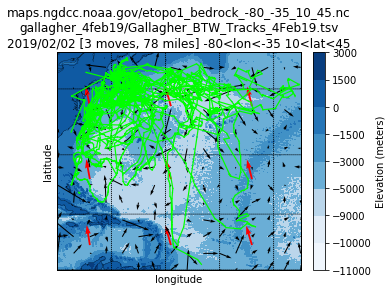

In [36]:
# Some settings you may want to experiment with
is3d = False
useBetterMap = True
contours = np.array([-11000., -10000., -9000., -5000., -3000., -1500,
                     0., 1500., 3000.])
LINECOLOR = 'lime' # https://matplotlib.org/examples/color/named_colors.html  
FILESHARK = 'gallagher_4feb19/Gallagher_BTW_Tracks_4Feb19.tsv'
# Set the output image file extension to 'svg' for huge, slow but high resolution images
# or 'png' for small, fast and slightly lower resolution
IMGEXTENSION = 'png'

# Load data and plot it
waypoints, idsForKml, lonmin, lonmax, latmin, latmax = loadSharkPath (FILESHARK)
map = makeMap (is3d, lonmin, lonmax, latmin, latmax)
drawContinents (map)        
elecdf, loncdf, latcdf = loadBathysphere (useBetterMap)
lonCurrent, latCurrent, uCurrent, vCurrent = loadCurrent (map, lonmin, lonmax, latmin, latmax)
lonDeclination, latDeclination, declination, udec, vdec = loadDeclination (map, lonmin, lonmax, latmin, latmax)

fKml = kmlFileOpen (idsForKml)
#drawDeclinationContours (map, lonDeclination, latDeclination, declination)
drawBathysphere (map, elecdf, loncdf, latcdf, contours)
drawDeclinationVectors (map, lonDeclination, latDeclination, udec, vdec) # Fails if before drawBathysphere
drawCurrent (map, lonCurrent, latCurrent, uCurrent, vCurrent) # Fails if before drawBathysphere
drawSharkPath (map, useBetterMap, LINECOLOR, FILESHARK, IMGEXTENSION, fKml, waypoints, \
               lonmin, lonmax, latmin, latmax) # Main plotting loop
    
# Scale values are pixels with 958x719 for dpi=150, or 1916x1438 for dpi=300 (too big for Discord).
# setpts value is smaller for faster movement and smaller file
print ('Convert using: ffmpeg -i outputs/gallagher%03d.{} -vf scale=958x719 -filter:v "setpts=0.4*PTS" outputs/gallagher.mp4' . \
       format (IMGEXTENSION))